# Исследование объявлений о продаже квартир.

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Знакомство с данными. 

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = 35

In [13]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В предоставленных данных отображено 23699 объявления квартир, информация по каждой из которых отражена в 22 показателях, в некоторых из показателей замечены пропуски, с которыми мы разберемся на этапе предобработки данных.

In [14]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

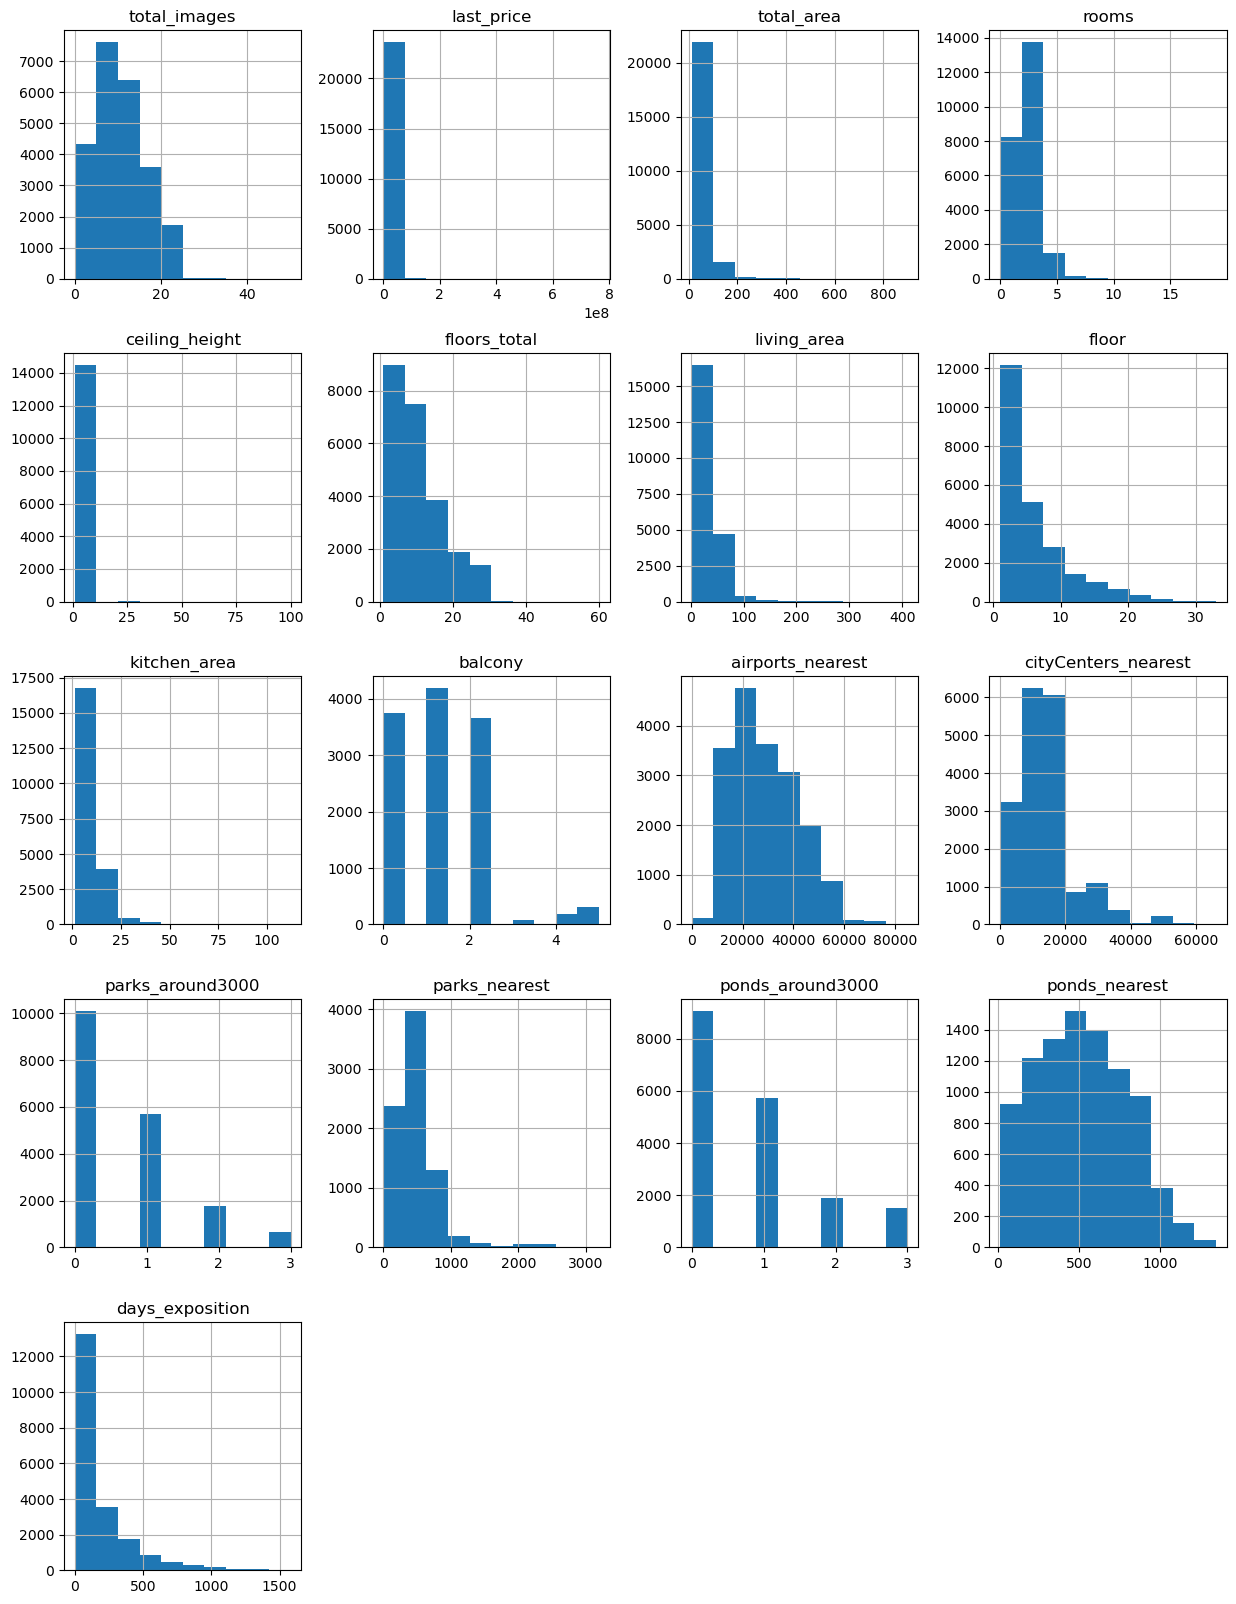

In [15]:
data.hist(figsize=(15, 20))
plt.show()

__Вывод:__ на построенных графиках мы можем рассмотреть предварительные ("сырые") показатели. Некоторые из графиков получились не особенно информативны, так, например, график с показателем о высоте потолков явно указывает нам на наличие вбросов. Разберемся с этим на следующем этапе. 

### Предобработка данных

#### Поиск пропущенных значений

Пустые значения присутствуют в следующих столбцах: `celling_heigh`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `locality_name`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition`.

Рассмотрим возможность заполнения пропусков там, где это возможно. Так, например, отсутствие значения в столбце `balcony`, может означать отсутствие балконов в квартире вовсе. То же самое может касаться столбцов `parks_around3000`,  `ponds_around3000`. Отсутствие значения в столбце `floors_total` может указывать на одноэтажное здание.

В столбце `is_apartment` тип данных указан в виде object, однако более логичным было бы оформить его в виде bool. Рассмотрим значения, входящие в данный столбец.

In [16]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Разумно предположить, что отсутствие значений в данном столбце предполагает значение `False`

Заполним пустые значения исходя из наших предположений.

In [17]:
for nan in ['balcony', 'parks_around3000', 'ponds_around3000']:
    data[nan].fillna(0, inplace=True)
    
data['is_apartment'].fillna(False, inplace=True)

In [18]:
data['floors_total'].isna().sum()

86

Так как строк с пропусками в колонке с количеством этажей немного, мы можем удалить данные строки.

In [19]:
data.dropna(subset=['floors_total'], inplace=True)

Также заменим пропущенные значения в `locality_name` на 'unknown' для дальнейшей работы с ними.

In [20]:
data['locality_name'].fillna('unknown', inplace=True)

Заполним пустые значения `kitchen_area` и `living_area` медианными значениями основываясь на коэффициентных соотношениях.

In [21]:
data['living_area'].describe()

count    21743.000000
mean        34.462781
std         22.037433
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [22]:
data['kitchen_area'].describe()

count    21382.000000
mean        10.564128
std          5.904316
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [23]:
kitchen_coef = data['kitchen_area'].median() / data['total_area'].median()
living_area_coef = data['living_area'].median() / data['total_area'].median()
data['kitchen_area'].fillna(data['total_area'] * kitchen_coef, inplace=True)
data['living_area'].fillna(data['total_area'] * living_area_coef, inplace=True)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23613 non-null  int64  
 1   last_price            23613 non-null  float64
 2   total_area            23613 non-null  float64
 3   first_day_exposition  23613 non-null  object 
 4   rooms                 23613 non-null  int64  
 5   ceiling_height        14495 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23613 non-null  float64
 8   floor                 23613 non-null  int64  
 9   is_apartment          23613 non-null  bool   
 10  studio                23613 non-null  bool   
 11  open_plan             23613 non-null  bool   
 12  kitchen_area          23613 non-null  float64
 13  balcony               23613 non-null  float64
 14  locality_name         23613 non-null  object 
 15  airports_nearest   

Отсутствие картографических данных может быть связано с техническими проблемами платформы, которые могут не позволить построить маршрут до ближайшего аэропорта. Отсутствие данных о жилой площади и площади кухни могут свидетельствовать о том, что возможно в данные попали офисные помещения.

#### Изменение типа данных

Столбец `first_day_exposition`, в котором размещена дата публикации объявления, представлен как object, чтобы облегчить работу с датами изменим формат на datetime64. `floors_total` представляет собой количество этажей в здании, однако при этом используется тип float64, изменим его на int64, который больше подходит для выражения целых чисел, то же самое сделаем с `balcony`.

In [25]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [26]:
for flt in ['floors_total', 'balcony']:
    data[flt] = data[flt].astype('int')

#### Поиск неявных дубликатов

Теперь из всех столбцов, только один `locality_name` содержит тип object, попробуем найти в нем неявные дубликаты.

In [28]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Большая путаница в данных между буквами 'е' и 'ё', а также между разнообразием видов поселений. Попробуем привести их к более общему виду

In [29]:
def trans_e(name):
    name = name.replace('ё', 'е')
    if 'поселок' in name:
        name = name.replace('городской поселок', 'поселок')
        name = name.replace('поселок городского типа', 'поселок')
        name = name.replace('коттеджный поселок', 'поселок')
    if 'село ' in name:
        name = name.replace('село', 'деревня')
    return name

data['locality_name'] = data['locality_name'].apply(trans_e)

#### Поиск выбросов

Благодаря построенным в ходе знакомства с данными графикам, было ясно, что в некоторых столбцах присутствуют вбросы. Проверим наличие резко отклоняющихся значений с помощью диаграммы размаха в интересующих нас показателях, таких как: `last_price`, `total_area`, `rooms`, `ceiling_height`.

<AxesSubplot:>

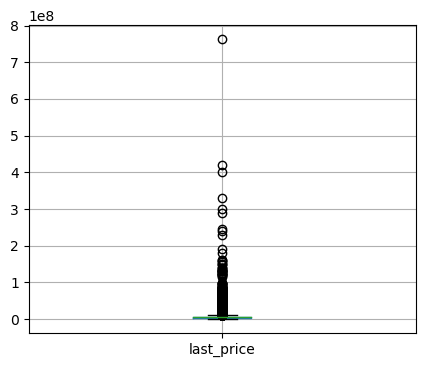

In [108]:
data.boxplot('last_price', figsize=(5, 4))

В столбце `last_price` присутствует большое количество резко выбивающихся значений, однако это может быть вполне ожидаемо для рынка недвижимости.

Отбросим значения с ценой выше 75 млн. руб., так как согласно графику они представлены в очень небольшом количестве.

In [44]:
len(data[data['last_price'] > 75_000_000])

67

Таким образом количество объявлений с резко отличающимся значением по стоимости было равно 67.

 _________________________

С ценой разобрались, перейдем к __площади квартиры__.

<AxesSubplot:>

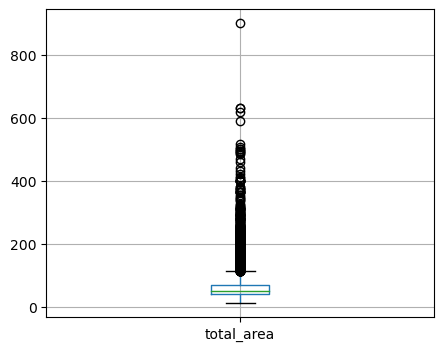

In [107]:
data.boxplot('total_area', figsize=(5, 4))  # график размаха содержащий выбросы

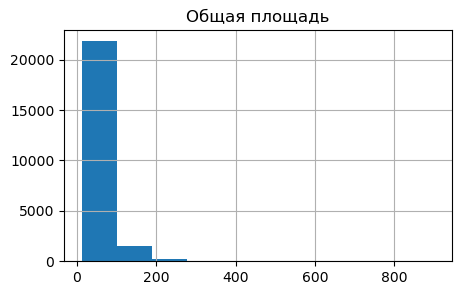

In [106]:
data['total_area'].hist(bins=10, figsize=(5, 3))
plt.title('Общая площадь')
plt.show()

Отбросим значения с площадью выше 200 кв. м., так как согласно графику они представлены в очень небольшом количестве.

In [47]:
len(data[data['total_area'] > 200])

226

Таким образом количество объявлений с резко отличающимся значением по площади было равно 227.

_______________

Рассмотрим график количества комнат в квартире.

<AxesSubplot:>

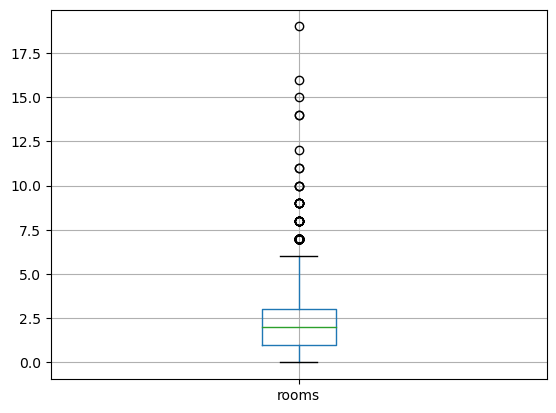

In [48]:
data.boxplot('rooms')

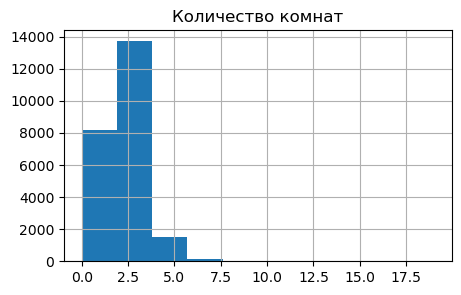

In [104]:
data['rooms'].hist(bins=10, figsize=(5, 3))
plt.title('Количество комнат')
plt.show()

Избавимся от выбросов с помощью формулы для нахождения выбросов через IQR.

In [50]:
data['rooms'].describe()

count    23613.000000
mean         2.071147
std          1.078380
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Посчитаем значение, которое является минимальным для того, чтобы считать его выбросом:

3 + (3 - 1) * 1.5 = 7.5

Все значения, которые выше 7.5 могут считаться выбросами, а также избавимся от значений равных 0.

In [51]:
len(data[(data['rooms'] > 7.5) | (data['rooms'] == 0)])

225

Таким образом количество объявлений с резко отличающимся значением количества комнат было равно 228.

-----------------------

Рассмотрим график высоты потолков в квартире.

<AxesSubplot:>

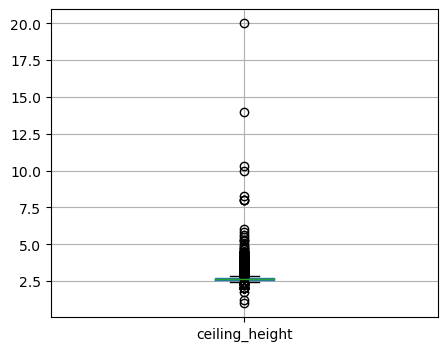

In [102]:
data.boxplot('ceiling_height', figsize=(5, 4))

Логично предположить, что некоторые выбивающиеся из ряда значения были искажены неправильным вводом, так например высота потолков 20м, могла быть вещественным значением 2.0м. Исправим это.

In [53]:
data.loc[data['ceiling_height'] > 20, 'ceiling_height'] = data.loc[data['ceiling_height'] > 20, 'ceiling_height'].apply(lambda x: x / 10)

In [54]:
data['ceiling_height'].unique()

array([ 2.7 ,   nan,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  2.65,  3.2 ,  2.61,  3.25,  3.45,
        2.77,  2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,
        2.47,  2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,
        2.51,  2.78,  2.76,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,
        2.59,  2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,
        3.55,  3.16,  3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.3 ,
        5.  ,  2.79,  2.95,  4.06,  2.94,  3.82,  3.54,  3.53,  2.83,
        4.7 ,  2.4 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,
        2.3 ,  3.57,  2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,
        3.95,  3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,
        3.24,  4.8 ,  4.5 ,  4.2 ,  3.36,  3.08,  3.68,  3.07,  3.37,
        3.09,  8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,
        2.68,  3.22,  3.27,  4.1 ,  2.93,  3.46,  3.47,  3.33,  3.63,
        3.32,  1.2 ,

In [55]:
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

Теперь избавимся от выбросов.

<AxesSubplot:>

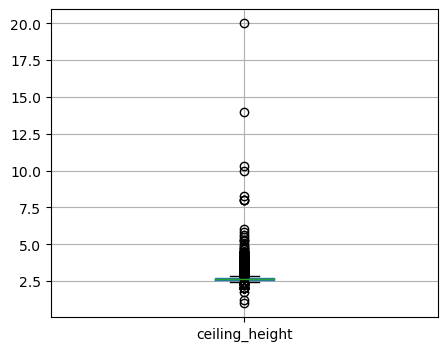

In [101]:
data.boxplot('ceiling_height', figsize=(5, 4))

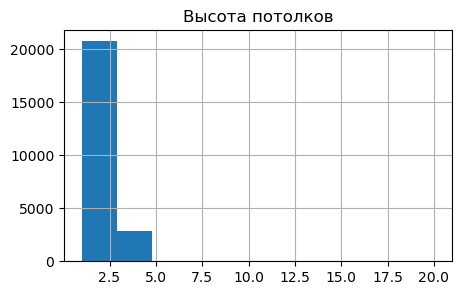

In [100]:
data['ceiling_height'].hist(figsize=(5, 3))
plt.title('Высота потолков')
plt.show()

Согласно закону в РФ минимальной высотой потолка является 2.4 м., отбросим эти значения. Также судя по гистограмме, в данных очень мало квартир, высота потолка которых превышает 5м, отбросим значения выше 5 м.

In [58]:
len(data.query('ceiling_height > 5 or ceiling_height < 2.4'))

37

Таким образом количество объявлений с резко отличающимся значением по высоте потолков было равно 37.

______________________________

Рассмотрим график площади кухни.

<AxesSubplot:>

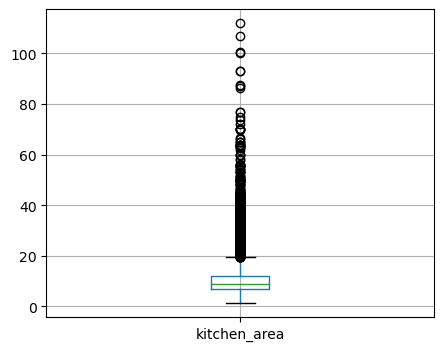

In [98]:
data.boxplot('kitchen_area', figsize=(5, 4))

Text(0.5, 1.0, 'Площадь кухни')

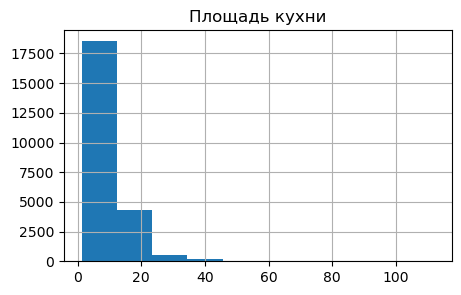

In [92]:
data['kitchen_area'].hist(bins=10, figsize=(5, 3))
plt.title('Площадь кухни')

Отбросим значения с площадью выше 40 кв. м., так как согласно графику они представлены в очень небольшом количестве.

In [61]:
len(data[data['kitchen_area'] > 40])

155

Таким образом количество объявлений с резко отличающимся значением по площади кухни было равно 155.

_____________________________________________

Соберем таблицу `good_data` с данными, подходящими для анализа, исходя из исследований проведенных выше.

In [63]:
good_data = (data
             .query('last_price <= 75_000_000')
             .query('total_area <= 200')
             .query('0 < rooms <= 7.5')
             .query('2.4 <= ceiling_height <= 5')
             .query('kitchen_area <= 40')
            )

**Вывод:** В данном шаге мы произвели предобработку данных: нашли пропущенные значения и заполнили некоторые из них, изменили тип данных некоторых столбцов на более подходящие, выявили неявные дубликаты и обработали их, а также произвели поиск аномалий из за наличия которых некоторые данные пришлось удалить, а некоторые исправить на корректные данные. Была создана новая таблица с обработанными данными - `good_data`

Добавим в получившуюся таблицу новые столбцы.

In [71]:
good_data['square_meter_price'] = good_data['last_price'] / good_data['total_area']
good_data['weekday_exposition'] = good_data['first_day_exposition'].dt.weekday
good_data['month_exposition'] = good_data['first_day_exposition'].dt.month
good_data['year_exposition'] = good_data['first_day_exposition'].dt.year

def floor_func(good_data):
    if good_data['floors_total'] == good_data['floor']:
        return 'последний'
    elif good_data['floor'] == 1:
        return 'первый'
    else:
        return 'другой'
    
good_data['floor_type'] = good_data.apply(floor_func, axis=1)
good_data['cityCenters_nearest'] = (good_data['cityCenters_nearest'] / 1000).round()


Мы модернизировали нашу таблицу `good_data` и добавили в нее новые столбцы:

- square_meter_price - цена одного квадратного метра

- weekday_exposition - день недели публикации объявления

- month_exposition - месяц публикации объявления

- year_exposition - год публикации объявления

- floor_type - тип этажа квартиры

А также изменили значения столбца расстояния до центра города - перевели из м в км и округлили до целых значений.




### Исследовательский анализ данных.

#### Изучим параметры объектов.

In [246]:
good_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,weekday_exposition,month_exposition,year_exposition,floor_type
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,False,...,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.600000,1,False,...,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.300000,4,False,...,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,91.730769,9,False,...,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой
5,10,2890000.0,30.40,2018-09-10,1,2.65,12,14.400000,5,False,...,0.0,NaN,0.0,NaN,55.0,95065.789474,0,9,2018,другой
6,6,3700000.0,37.30,2017-11-02,1,2.65,26,10.600000,6,False,...,0.0,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,41.307692,22,False,...,0.0,NaN,0.0,NaN,NaN,110544.692737,3,4,2019,другой
8,20,2900000.0,33.16,2018-05-23,1,2.65,27,15.430000,26,False,...,0.0,NaN,0.0,NaN,189.0,87454.764777,2,5,2018,другой
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.600000,7,False,...,0.0,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,другой
10,5,5050000.0,39.60,2017-11-16,1,2.67,12,20.300000,3,False,...,1.0,310.0,2.0,553.0,137.0,127525.252525,3,11,2017,другой


array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

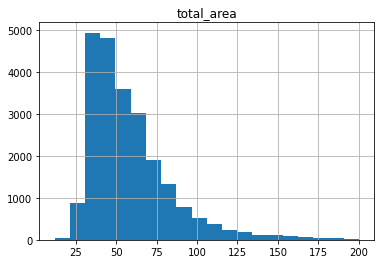

In [247]:
good_data.hist('total_area', bins=20)

На данном графике мы можем видеть, что площадь большинства квартир расположена в диапазоне 30-50 кв. метров. Распределение со  скосом в правую часть.

array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

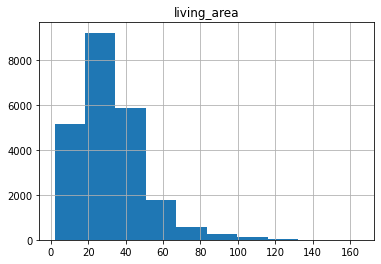

In [248]:
good_data.hist('living_area')

На графике жилой площади мы видим, что пик значений приходится на 20-35 кв.м.

array([[<AxesSubplot:title={'center':'kitchen_area'}>]], dtype=object)

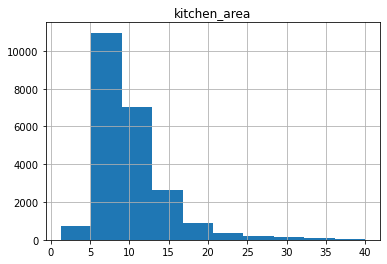

In [249]:
good_data.hist('kitchen_area')

На графике с площадью кухни можно наблюдать, что пик значений приходится примерно на 5-8 кв.м. Распределение со скосом в правую часть.

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

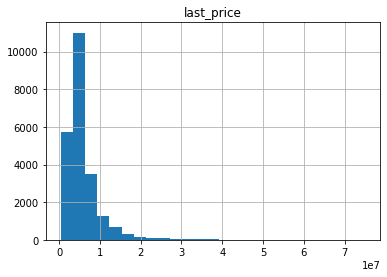

In [250]:
good_data.hist('last_price', bins=25)

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

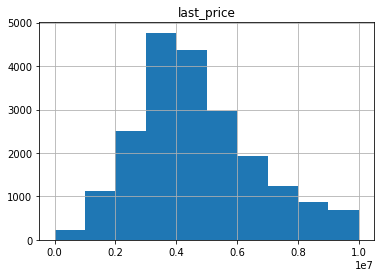

In [251]:
good_data.hist('last_price', range=(0, 10_000_000))

На графике с ценой продажи можно наблюдать, что пик значений приходится примерно на 25-45 млн. руб.

array([[<AxesSubplot:title={'center':'rooms'}>]], dtype=object)

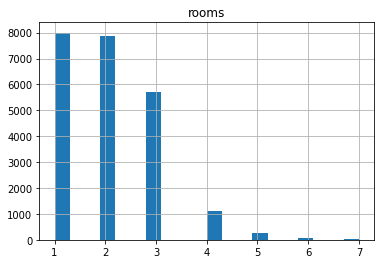

In [252]:
good_data.hist('rooms', bins=20)

На графике с комнатами можно видеть, что наибольшее и премерно равное количество приходится на однокомнатные и двухкомнатные квартиры, трехкомнатные квартир примерно на четверть меньше. Четерехкомнатные и пятикомнатные квартиры занимают очень низкую долю.

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

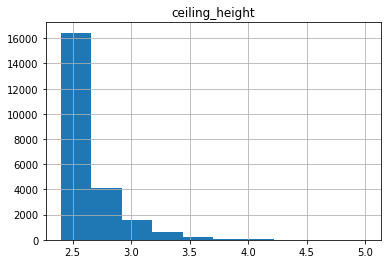

In [253]:
good_data.hist('ceiling_height')

На графике с высотой потолков мы видим, что пик значений приходится на высоту 2.4 - 2.6м.

array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

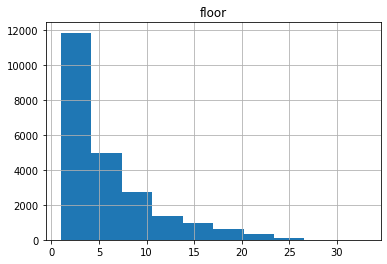

In [254]:
good_data.hist('floor')

На графике отражающем этаж квартиры, наибольшие значения приходятся на значения с первого по третий этаж, что вероятно вызвано большим количеством немногоэтажных зданий в выборке.

<AxesSubplot:xlabel='floor_type'>

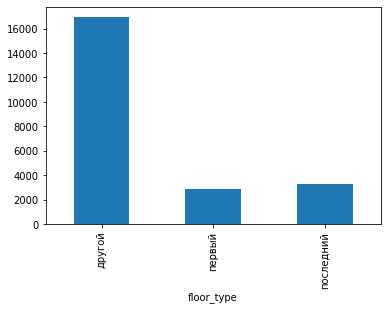

In [255]:
good_data.groupby('floor_type')['rooms'].count().plot(kind='bar')

На данном графике мы видим, что больше всего в объявлениях предоставленны не первые и не последний этажи.

array([[<AxesSubplot:title={'center':'floors_total'}>]], dtype=object)

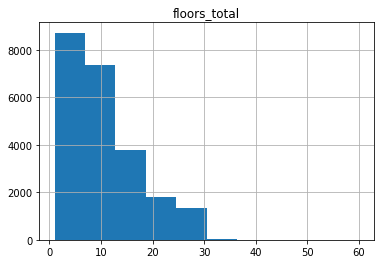

In [256]:
good_data.hist('floors_total')

На данном графике мы видим, что в большинстве объявлений указано количество этажей в здании примерно от 1 до 12.

array([[<AxesSubplot:title={'center':'cityCenters_nearest'}>]],
      dtype=object)

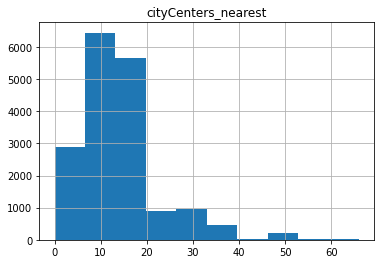

In [257]:
good_data.hist('cityCenters_nearest')

На данном графике можно наблюдать, что в большинстве случаев расстояние до центра города составляет от 7 до 19 км.

array([[<AxesSubplot:title={'center':'airports_nearest'}>]], dtype=object)

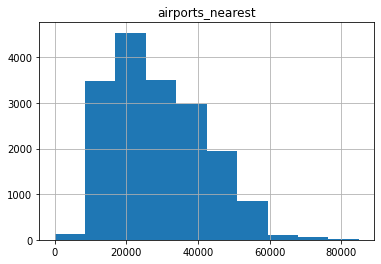

In [258]:
good_data.hist('airports_nearest')

На данном графике можно наблюдать, что в большинстве случаев расстояние до аэропорта распологается в районе от 8 до 24 км.

array([[<AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

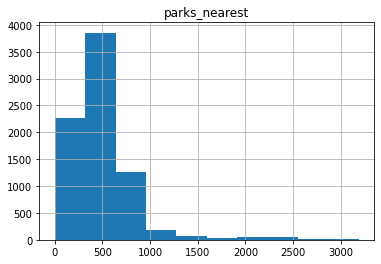

In [259]:
good_data.hist('parks_nearest')

На данном графике мы видим, что почти все квартиры располагаются в пределах 1км. до ближайшего парка.

In [260]:
good_data['parks_nearest'].isna().sum()

15256

In [261]:
len(good_data['parks_nearest'])

23049

Однако при этом стоит учитывать, что данный параметр заполнен лишь у 34% объявлений.

array([[<AxesSubplot:title={'center':'month_exposition'}>]], dtype=object)

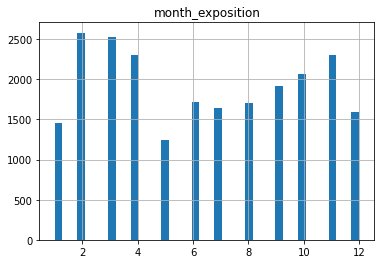

In [262]:
good_data.hist('month_exposition', bins=40)

На данном графике мы видим, что большинство объявлений о продаже квартир были выставлены в январе и феврале, меньше всего в мае.

array([[<AxesSubplot:title={'center':'weekday_exposition'}>]],
      dtype=object)

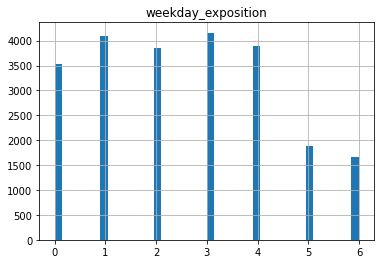

In [263]:
good_data.hist('weekday_exposition', bins=40)

Согласно графику, объявления о продаже большинства квартир были опубликованы в будние дни

__________________________________________

#### Как быстро продавались квартиры.

Рассмотрим график на котором указано количество дней с момента публикации объявления до момента продажи. 

array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

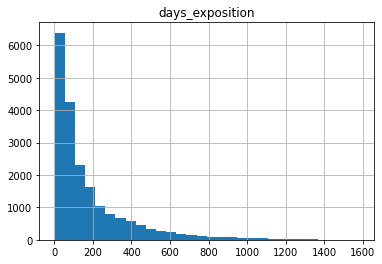

In [264]:
good_data.hist('days_exposition', bins=30)

In [265]:
good_data['days_exposition'].describe()

count    19984.000000
mean       179.988841
std        218.166638
min          1.000000
25%         45.000000
50%         95.000000
75%        230.250000
max       1580.000000
Name: days_exposition, dtype: float64

Согласно графику, чаще всего квартиры продаются в ближайшие 100 дней с момента публикации объявления. О чем и свидетельствует медиана, согласно которой половина всех объвлений продается в срок до 95 дней, а другая половина растягивается на срок до 1580 дней. Среднее арифметическое время продажи составляет 180 дней. Такая большая разница между медианой и средним обусловлена наличием выбросов.

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта

Построим графики корреляции, благодаря которым мы сможем выяснить какие параметры коррелируют со стоимостью продажи квартиры, а какие нет.

_Влияние общей площади на цену квартиры_

<AxesSubplot:xlabel='last_price', ylabel='total_area'>

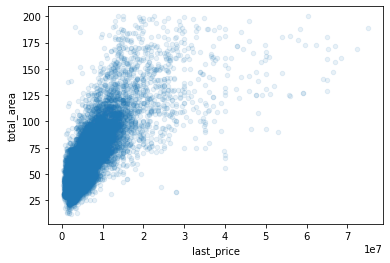

In [266]:
good_data.plot(kind='scatter', x='last_price', y='total_area', alpha=0.1)

In [267]:
good_data.loc[:, ['last_price', 'total_area']].corr()

,last_price,total_area
last_price,1.000000,0.745188
total_area,0.745188,1.000000


Как мы видим, присутствует довольно высокая корреляция между площадью квартиры и ее стоимостью.

______________________________________________

_Влияние жилой площади на цену квартиры_

<AxesSubplot:xlabel='last_price', ylabel='living_area'>

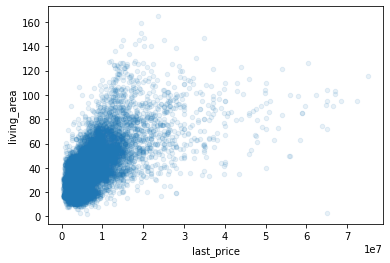

In [268]:
good_data.plot(kind='scatter', x='last_price', y='living_area', alpha=0.1)

In [269]:
good_data.loc[:, ['last_price', 'living_area']].corr()

,last_price,living_area
last_price,1.000000,0.648765
living_area,0.648765,1.000000


Как мы видим, присутствует средняя по степени корреляция между площадью квартиры и ее стоимостью.

_____________________________

_Влияние площади кухни на цену квартиры_

<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

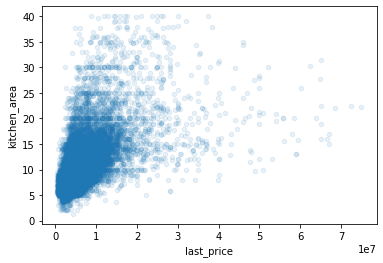

In [270]:
good_data.plot(kind='scatter', x='last_price', y='kitchen_area', alpha=0.1)

In [271]:
good_data.loc[:, ['last_price', 'kitchen_area']].corr()

,last_price,kitchen_area
last_price,1.000000,0.566074
kitchen_area,0.566074,1.000000


Как мы видим, присутствует слабая корреляция между площадью кухни квартиры и ее стоимостью.

_____________________________

_Влияние количества комнат на цену квартиры_

<AxesSubplot:xlabel='last_price', ylabel='rooms'>

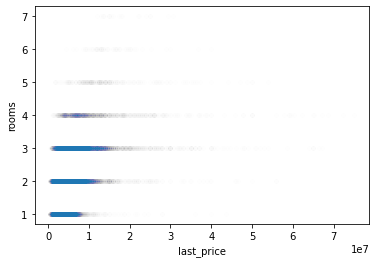

In [272]:
good_data.plot(kind='scatter', x='last_price', y='rooms', alpha=0.002)

In [273]:
good_data.loc[:, ['last_price', 'rooms']].corr()

,last_price,rooms
last_price,1.000000,0.452001
rooms,0.452001,1.000000


Как мы видим, присутствует слабая корреляция между количеством комнат квартиры и ее стоимостью.

--------------------------------

_Влияние этажа, на котором расположена квартира на цену квартиры_

Создадим график, на основе медианных значений стоимости квартир в зависимости от этажа, на котором они располагаются.

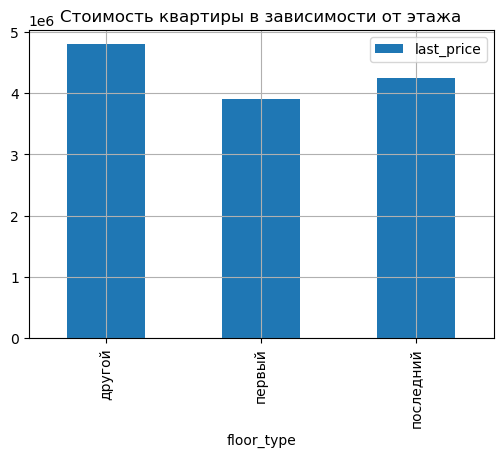

In [117]:
floor_type_grouped = good_data.groupby('floor_type').agg({'last_price' : 'median'})
floor_type_grouped.plot(kind='bar', figsize=(6, 4), grid=True)
plt.title('Стоимость квартиры в зависимости от этажа')
plt.show()

На данном графике мы можем видить, что стоимость квартир расположенных ни на первом, ни на последнем этаже в среднем заметно превышает другие показатели. Таким образом, можно сделать вывод, что этаж на котором расположена квартира влияет на ее стоимость.

------------------

_Влияние даты размещения на цену квартиры_

Создадим график, на основе медианных значений стоимости квартир в зависимости от даты размещения объявления.

Рассмотрим зависимость от __дня недели__

<AxesSubplot:xlabel='last_price', ylabel='weekday_exposition'>

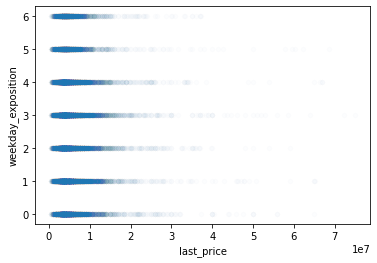

In [280]:
good_data.plot(kind='scatter', x='last_price', y='weekday_exposition', alpha=0.01)

In [281]:
good_data.loc[:, ['last_price', 'weekday_exposition']].corr()

,last_price,weekday_exposition
last_price,1.000000,-0.016019
weekday_exposition,-0.016019,1.000000


Как мы видим, присутствует очень слабая корреляция между днем публикации объявления о продаже квартиры и ее стоимостью.

Рассмотрим зависимость от __месяца__

<AxesSubplot:xlabel='last_price', ylabel='month_exposition'>

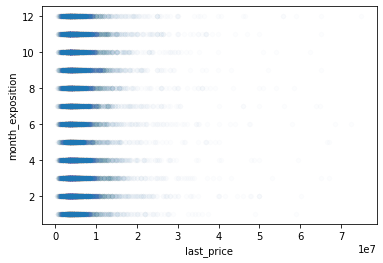

In [282]:
good_data.plot(kind='scatter', x='last_price', y='month_exposition', alpha=0.01)

In [283]:
good_data.loc[:, ['last_price', 'month_exposition']].corr()

,last_price,month_exposition
last_price,1.000000,0.008547
month_exposition,0.008547,1.000000


Мы можем наблюдать практически полное отсутствие корреляции между месяцем публикации объявления о продаже квартиры и ее стоимостью.

Рассмотрим зависимость от __года__

<AxesSubplot:xlabel='last_price', ylabel='year_exposition'>

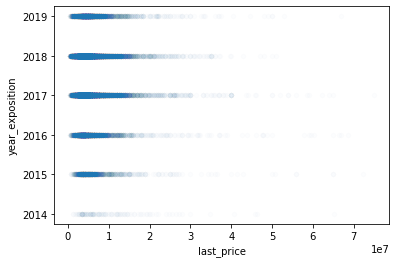

In [284]:
good_data.plot(kind='scatter', x='last_price', y='year_exposition', alpha=0.01)

In [285]:
good_data.loc[:, ['last_price', 'year_exposition']].corr()

,last_price,year_exposition
last_price,1.00000,-0.04803
year_exposition,-0.04803,1.00000


Как мы видим, присутствует слабая корреляция между годом публикации объявления о продаже квартиры и ее стоимостью.

_____________________________

#### Средняя цена за кв. м.

Рассмотрим десять населенных пунктов с наибольшим числом объявлений

In [316]:
bt = good_data.pivot_table(index='locality_name', values=['square_meter_price', 'rooms'], aggfunc={'square_meter_price': 'median', 'rooms': 'count'})
bt.rename(columns={'rooms': 'count_expositions'}, inplace=True)
bt = bt.sort_values('count_expositions', ascending=False).head(10)
bt.sort_values('square_meter_price', ascending=False)

,count_expositions,square_meter_price
locality_name,,
Санкт-Петербург,15212,104347.826087
Пушкин,360,99865.712506
поселок Парголово,322,91984.436588
деревня Кудрово,283,91666.666667
поселок Мурино,525,84285.714286
поселок Шушары,434,76747.967480
Колпино,337,74722.222222
Гатчина,307,67796.610169
Всеволожск,391,65789.473684


<AxesSubplot:xlabel='locality_name'>

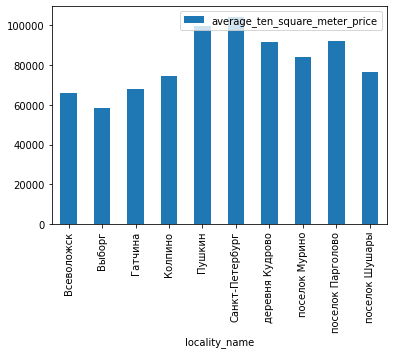

In [288]:
bt.pivot_table(index='locality_name', values='square_meter_price', aggfunc='median').plot(kind='bar')

Как мы видим из графика, по медианному показателю самая низкая стоимость за квадратный метр находится во Выборге, самая высокая стоимость также остается в Санкт-Петербурге.

#### Средняя цена за каждый км от центра

Рассмотрим количество и стоимость квартир в зависимости от расстояния до центра города.

In [74]:
price_center = good_data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest', values=['last_price', 'rooms'], aggfunc={'last_price': 'median', 'rooms': 'count'})
price_center.rename(columns={'rooms':'count'}, inplace=True)
price_center

,last_price,count
cityCenters_nearest,,
0.0,13500000.0,22
1.0,10050000.0,168
2.0,9500000.0,276
3.0,8300000.0,335
4.0,8990000.0,659
5.0,8970000.0,849
6.0,8500000.0,561
7.0,7500000.0,397
8.0,7300000.0,571


Исходя из количества объявлений возьмем квартиры, расположенные от 1 до 23 км от центра и построим график стоимости в зависимости от расстояния до центра города.

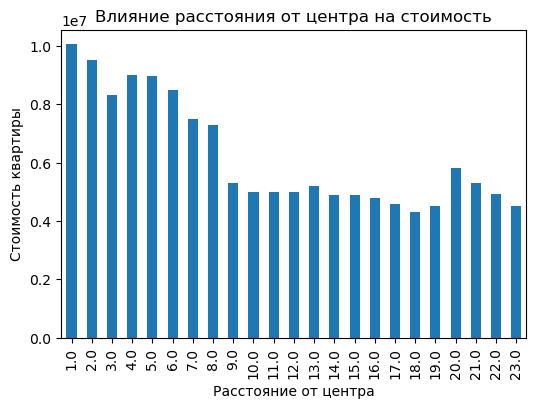

In [83]:
price_center_sample = price_center.loc[1:23, 'last_price']
price_center_sample.plot(kind='bar', figsize=(6, 4))
plt.ylabel('Стоимость квартиры')
plt.xlabel('Расстояние от центра')
plt.title('Влияние расстояния от центра на стоимость')
plt.show()

На графике видно, что расстояние до центра явно коррелирует со стоимостью квартиры.

Рассчитаем разность в стоимости между квартирами, расположенными на разном расстоянии от центра.

In [291]:
price_center_sample.diff().median()

-245000.0

Таким образом, стоимость квартиры за каждый километр от центра города уменьшается примерно на 245000 руб. 

Узнаем коэффициент корреляции.

In [292]:
pd.DataFrame(
    {
    'last_price': price_center_sample,
    'cityCenters_nearest': price_center_sample.index
    },
    index=range(1, 24)
).corr()

,last_price,cityCenters_nearest
last_price,1.000000,-0.849891
cityCenters_nearest,-0.849891,1.000000


Мы можем наблюдать высокую отрицательную корреляцию между стоимостью квартиры и расстоянием до центра города.

____________________

**Вывод:** В данном шаге мы детально изучили параметры объектов и построили для каждого отдельную гистограмму, в ходе чего выяснилось, что площадь большинства квартир расположена в диапазоне 30-60 кв. метров.  Пик значений жилой площади приходится на 20-35 кв.м. На графике с площадью кухни можно наблюдать, что пик значений приходится примерно на 5-8 кв.м. Пик значений цены приходится примерно на 25-45 млн. руб. Большинство квартир - однокомнатные и двухкомнатные. Пик значений высоты потолком приходится на 2.4 - 2.6м. На графике отражающем этаж квартиры, наибольшие значения приходятся на значения с первого по третий этаж, что вероятно вызвано большим количеством немногоэтажных зданий в выборке. В большинстве случаев расстояние до центра города составляет от 7 до 19 км. Почти все квартиры располагаются в пределах 1км. до ближайшего парка, однако при этом стоит учитывать, что данный параметр заполнен лишь у 34% объявлений. 

В большинстве случаев, квартиры продавались в ближайшие 100 дней с момента объявления.

Также мы рассмотрели факторы, которые влияют на стоимость квартир. Из влияемых факторов оказались: площадь квартиры, количество комнат, этаж и расстояние до центра. Дата подачи объявления не сыграла важную роль, однако присутствует слабая связь между годом объявления и стоимостью.

Мы рассчитали среднюю цену за кв. м. в десяти наиболее населенных пунктах, оказалось что самая высокая цена в Санкт-Петербурге, а самая низкая в Всеволожске. 

Оказалось, что расстояние до города центра играет очень важную роль в формировании цены за квартиру. Мы рассчитали коэффициент корреляции в г. Санкт-Петербург и выяснили, что стоимость квартиры за каждый километр от центра города уменьшается примерно на 161250 руб.

### Общий вывод

В данном проекте мы рассмотрели данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

При открытии файла мы построили графики для каждого показателя из которых было заметно, что некоторые из данных были искажены, с чем мы и начали заниматься на этапе предобработки данных. В первую очередь мы начали с поиска пропущенных значений. Некоторые из пропусков были обусловлены вполне логично, так, например, отсутствие данных в столбце с балконами могло означать отсутствие того самого балкона. Некоторые из пропусков мы заполнили медианными значениями. В целом мы пришли к выводу, что отсутствие картографических данных может быть связано с техническими проблемами платформы, непозволяющим, например, построить маршрут до ближайшего аэропорта. Отсутствие данных о жилой площади и площади кухни могут свидетельствовать о том, что возможно в данные попали офисные помещения.

Для дальнейшей удобной работы с данными мы изменили типы данных, на более подходящие, так, например, столбец `first_day_exposition`, в котором размещена дата публикации объявления, представлен как object, чтобы облегчить работу с датами мы изменили формат на datetime64.

Разобраться с неявными дубликатами было непросто, однако они могли присутствовать только в столбце `locality_name`, так как он один содержит тип object. Большая путаница возникла в использовании в данных букв 'е' и 'ё'. Мы исправили данную проблему заменив все буквы на 'е'.

Благодаря построенным в начале исследования графикам, было ясно, что в некоторых столбцах присутствуют вбросы. Найти данные вбросы нам помог график размаха, и рассчет выбросов благодаря формуле. Таблицу с новыми данными без вбросов мы назвали `good_data` и в дальнейшем работа велась с ней.

В следующем шаге мы модернизировали нашу таблицу `good_data` и добавили в нее новые столбцы:

- square_meter_price - цена одного квадратного метра

- weekday_exposition - день недели публикации объявления

- month_exposition - месяц публикации объявления

- year_exposition - год публикации объявления

- floor_type - тип этажа квартиры

А также изменили значения столбца расстояния до центра города - перевели из м в км и округлили до целых значений.

Далее мы подробно рассмотрели и изучили параметры объектов, построили для каждого отдельную гистограмму, в ходе чего выяснилось, что площадь большинства квартир расположена в диапазоне 30-50 кв. метров. Пик значений жилой площади приходится на 20-35 кв.м. На графике с площадью кухни можно наблюдать, что пик значений приходится примерно на 5-8 кв.м. Пик значений цены приходится примерно на 25-45 млн. руб. Большинство квартир - однокомнатные и двухкомнатные. Пик значений высоты потолком приходится на 2.4 - 2.6м. На графике отражающем этаж квартиры, наибольшие значения приходятся на значения с первого по третий этаж, что вероятно вызвано большим количеством немногоэтажных зданий в выборке. В большинстве случаев расстояние до центра города составляет от 7 до 19 км. Почти все квартиры располагаются в пределах 1км. до ближайшего парка, однако при этом стоит учитывать, что данный параметр заполнен лишь у 34% объявлений.

В большинстве случаев, квартиры продавались в ближайшие 100 дней с момента объявления.

Также мы рассмотрели факторы, которые влияют на стоимость квартир. Из влияемых факторов оказались: площадь квартиры, количество комнат, этаж и расстояние до центра. Дата подачи объявления не сыграла важную роль, однако присутствует слабая связь между годом объявления и стоимостью.

Мы рассчитали среднюю цену за кв. м. в десяти наиболее населенных пунктах, оказалось что самая высокая цена в Санкт-Петербурге, а самая низкая в Выборге.

Оказалось, что расстояние до города центра играет очень важную роль в формировании цены за квартиру. Мы рассчитали коэффициент корреляции в г. Санкт-Петербург и выяснили, что стоимость квартиры за каждый километр от центра города уменьшается примерно на 245000 руб.



